### Temperature Modeling with SARIMA in Python

RESOURCES USED:

https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b
https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b
https://stephenallwright.com/interpret-rmse/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_monthly = pd.read_csv('Canada_monthly.csv')

In [3]:
df_monthly['Month'] = pd.to_datetime(df_monthly['Date'])

In [4]:
data = df_monthly[['Month', 'MONTHLY_TEMPERATURE_TORONTO']].rename(columns={'MONTHLY_TEMPERATURE_TORONTO': 'Temperature'}).set_index('Month')['1/1/1960':'12/1/2009']

In [5]:
data

,Temperature
Month,
1960-01-01,-5.119355
1960-02-01,-4.406897
1960-03-01,-6.035484
1960-04-01,7.506667
1960-05-01,13.554839
...,...
2009-08-01,20.619355
2009-09-01,16.856667
2009-10-01,8.716129


In [6]:
NUM_ROWS = data.shape[0]

<AxesSubplot:xlabel='Month'>

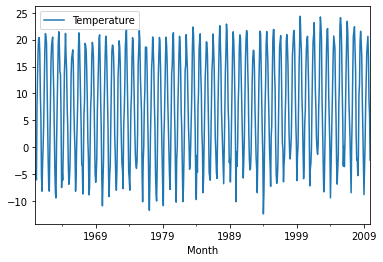

In [7]:
data.plot()

<AxesSubplot:xlabel='Month'>

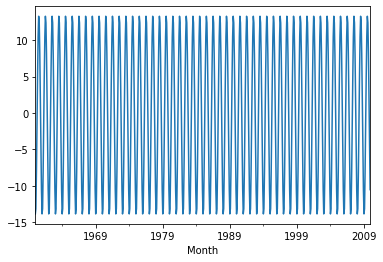

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data, model="additive")
seasonality=decompose_data.seasonal
seasonality.plot()

In [9]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.Temperature, autolag = 'AIC')
print(f"ADF is {dftest[0]}")
print(f"p-value is {dftest[1]}")

ADF is -3.8920482321317005
p-value is 0.002094153381028176


In [10]:
import statsmodels.api as sm

In [11]:
model=sm.tsa.statespace.SARIMAX(data['Temperature'],order=(0, 1, 1),seasonal_order=(0,1,2,12))
results=model.fit()

C:\Users\frenc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\frenc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

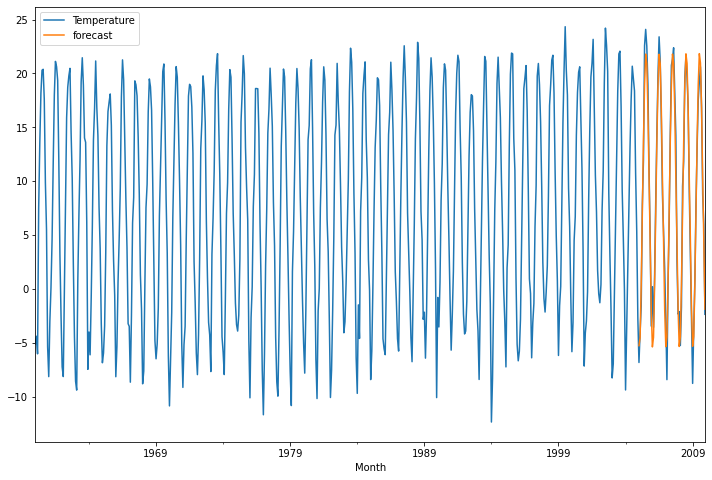

In [12]:
data['forecast']=results.predict(start=NUM_ROWS-12*5,end=NUM_ROWS,dynamic=True)
data[['Temperature','forecast']].plot(figsize=(12,8))

In [13]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1] + DateOffset(months=x)for x in range(0,12*10+1)]

In [14]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)

In [15]:
data=pd.concat([data,pred_date])

<AxesSubplot:>

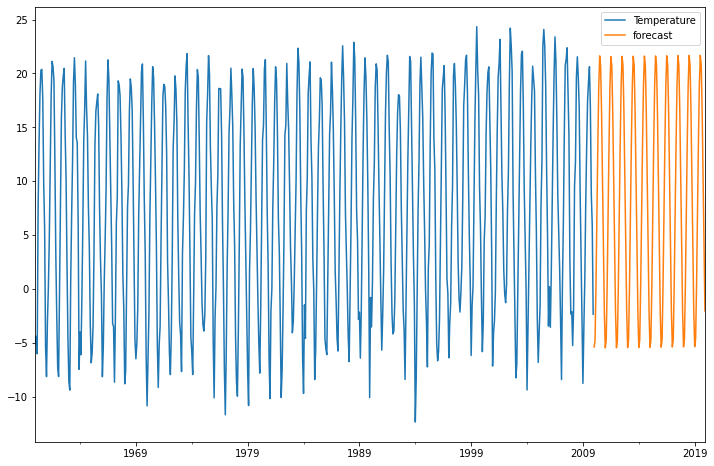

In [16]:
data['forecast'] = results.predict(start = NUM_ROWS, end = NUM_ROWS+12*10, dynamic= True)  
data[['Temperature', 'forecast']].plot(figsize=(12, 8))

In [17]:
pred_df = data['forecast']['2010/01/01':'2019/12/01'].to_frame()
pred_df = pred_df.rename(columns={'forecast': 'Temperature'})

In [18]:
df_monthly = pd.read_csv('Canada_monthly.csv')
df_monthly['Month'] = pd.to_datetime(df_monthly['Date'])
actual_df = df_monthly[['Month', 'MONTHLY_TEMPERATURE_TORONTO']].rename(columns={'MONTHLY_TEMPERATURE_TORONTO': 'Temperature'}).set_index('Month')['1/1/2010':'12/1/2019']

In [19]:
diff_df = (actual_df - pred_df) ** 2

In [20]:
rmse = float((diff_df.sum() / len(diff_df)) ** (1/2))
rmse

2.2640069777653644

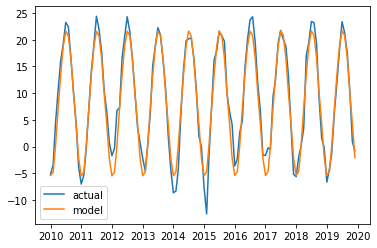

In [21]:
plt.plot(actual_df, label='actual')
plt.plot(pred_df, label='model')
plt.legend()
plt.show()

In [31]:
df_graph = pd.DataFrame()
df_graph['actual'] = actual_df
df_graph['prediction'] = pred_df

In [32]:
df_graph

,actual,prediction
Month,,
2010-01-01,-5.225806,-5.396084
2010-02-01,-3.367857,-4.829948
2010-03-01,4.361290,0.118067
2010-04-01,10.496667,7.074485
2010-05-01,15.993548,13.339601
...,...,...
2019-08-01,21.293333,20.823416
2019-09-01,17.566667,16.614761
2019-10-01,10.535484,10.111670


In [33]:
import plotly.express as px

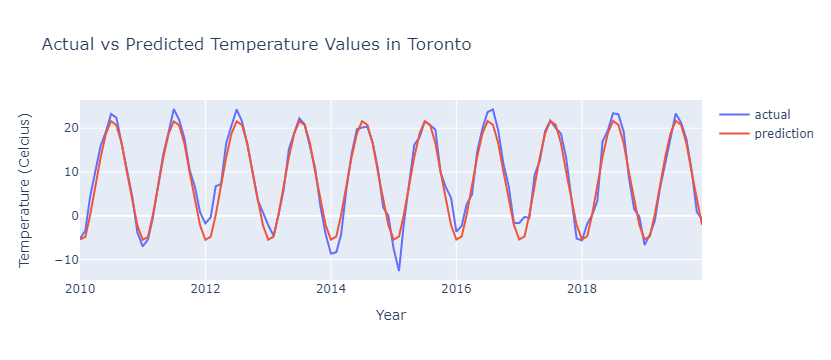

In [38]:
import plotly.express as px
fig = px.line(df_graph, y=['actual','prediction'], title='Actual vs Predicted Temperature Values in Toronto')
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Temperature (Celcius)",
    legend_title="")
fig.show()